## NN Back Propagation（神经网络反向传播）

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report #评价报告

In [5]:
def load_data(path, transpose=True):
    data = sio.loadmat(path)
    y = data.get('y') #(5000, 1)
    y = y.reshape(y.shape[0]) # make it back to column vector
    
    X = data.get('X') # (5000, 400)
    
    if transpose:
        # for this dataset, you need a transpose to get the orientation right
        X = np.array([im.reshape((20, 20)).T for im in X])
        
        # and I flat the image again to preserve the vector presentation
        X = np.array([im.reshape(400) for im in X])
        
    return X, y

In [7]:
X, _ = load_data('ex4data1.mat')

In [8]:
def plot_100_image(X):
    size = int(np.sqrt(X.shape[1]))
    
    # smaple 100 image, reshape, reorg it
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100) # 100*400
    sample_images = X[sample_idx, :]
    
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))
    
    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

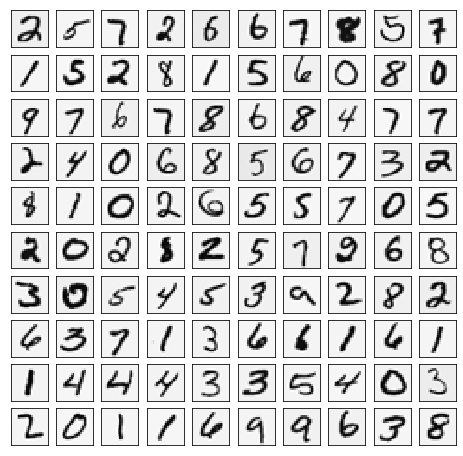

In [9]:
plot_100_image(X)
plt.show()

## 代价函数

In [10]:
X_raw, y_raw = load_data('ex4data1.mat', transpose=False)
X = np.insert(X_raw, 0, np.ones(X_raw.shape[0]), axis=1) #增加全部为1的一列
X.shape

(5000, 401)

In [11]:
y_raw

array([10, 10, 10, ...,  9,  9,  9], dtype=uint8)

In [12]:
def expand_y(y):
    res = []
    for i in y:
        y_array = np.zeros(10)
        y_array[i - 1] = 1
        
        res.append(y_array)
        
    return np.array(res)

In [13]:
y = expand_y(y_raw)
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

## 读取权重

In [14]:
def load_weight(path):
    data = sio.loadmat(path)
    return data['Theta1'], data['Theta2']

In [15]:
t1, t2 = load_weight('ex4weights.mat')
t1.shape, t2.shape

((25, 401), (10, 26))

In [16]:
def serialize(a, b):
    return np.concatenate((np.ravel(a), np.ravel(b)))
# 序列化2矩阵
# 在这个nn架构中， 我们有theta1(25, 401), theta(10, 26), 它们的梯度是delta1, delta2

In [17]:
theta = serialize(t1, t2) # 扁平化参数， 25*401_10*26=10285
theta.shape

(10285,)

## feed forward(前向传播)
> (400 + 1)->(25 + 1)->(10)

In [18]:
def feed_forward(theta, X):
    t1, t2 = deserialize(theta) # t1: (25,401) t2:(10,26)
    m = X.shape[0]
    a1 = X # 5000*401
    
    z2 = a1 @ t1.T # 5000*25
    a2 = np.insert(sigmoid(z2), 0, np.ones(m), axis=1) # 5000*26
    
    z3 = a2 @ t2.T # 5000*10
    h = sigmoid(z3) # 5000*10, this is h_theta(X)
    
    return a1, z2, a2, z3, h # you need all those for backprop

In [19]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z)) 

In [20]:
def deserialize(seq):
    return seq[:25 * 401].reshape(25, 401), seq[25 * 401:].reshape(10, 26)

In [21]:
_, _, _, _, h = feed_forward(theta, X)
h # 5000*10

array([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
        4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
       [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
        2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
       [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
        6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
       ...,
       [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
        2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
       [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
        1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
       [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
        5.73434571e-03, 6.96288990e-01, 8.18576980e-02]])

## 代价函数

In [22]:
def cost(theta, X, y):
    m = X.shape[0] # get the data size m
    
    _, _, _, _, h = feed_forward(theta, X)
    
    # np.multiply is pairwise operation
    pair_computation =  -np.multiply(y, np.log(h)) - np.multiply((1 - y), np.log(1 - h))
    
    return pair_computation.sum() / m

In [23]:
cost(theta, X, y)

0.2876291651613189

## 正则化代价函数

In [24]:
def regularized_cost(theta, X, y, l=1):
    t1, t2 = deserialize(theta) # t1: (25,401) t2: (10,26)
    m = X.shape[0]
    
    reg_t1 = (1 / (2 * m)) * np.power(t1[:, 1:], 2).sum() # this is how you ignore first col
    reg_t2 = (1 / (2 * m)) * np.power(t2[:, 1:], 2).sum()
    
    return cost(theta, X, y) + reg_t1 + reg_t2

In [25]:
regularized_cost(theta, X, y)

0.38376985909092365

## 反向传播

读取数据和权重过程与前向传播相同

In [26]:
X.shape, y.shape

((5000, 401), (5000, 10))

In [27]:
t1.shape, t2.shape

((25, 401), (10, 26))

In [28]:
theta.shape

(10285,)

In [29]:
def sigmoid_gradient(z):
    # pairwise op is key for this to work on both vector and matrix
    
    return np.multiply(sigmoid(z), 1 - sigmoid(z))

In [30]:
sigmoid_gradient(0)

0.25

## theta gradient

super hard to get this right... the dimension is so confusing

In [31]:
def gradient(theta, X, y):
    # initialize
    t1, t2 = deserialize(theta) # t1: (25,401) t2: (10,26)
    m = X.shape[0]
    
    delta1 = np.zeros(t1.shape) # (25, 401)
    delta2 = np.zeros(t2.shape) #(10, 26)
    
    a1, z2, a2, z3, h = feed_forward(theta, X)
    
    for i in range(m):
        a1i = a1[i, :] # (1,401)
        z2i = z2[i, :] # (1,25)
        a2i = a2[i, :] # (1,26)
        
        hi = h[i, :] # (1,10)
        yi = y[i, :] # (1,10)
        
        d3i = hi - yi # (1,10)
        
        z2i = np.insert(z2i, 0, np.ones(1)) # make it (1, 26) to compute d2i
        d2i = np.multiply(t2.T @ d3i, sigmoid_gradient(z2i)) # (1, 26)
        
        # careful with np vector transpose
        delta2 += np.matrix(d3i).T @ np.matrix(a2i) # (1, 10).T @ (1, 26) -> (10, 26)
        delta1 += np.matrix(d2i[1:]).T @ np.matrix(a1i) # (1,25).T @ (1, 401) -> (25, 401)
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    return serialize(delta1, delta2)

In [32]:
d1, d2 = deserialize(gradient(theta, X, y))

In [33]:
d1.shape, d2.shape

((25, 401), (10, 26))

## 梯度校验

In [34]:
def gradient_checking(theta, X, y, epsilon, regularized=False):
    def a_numeric_grad(plus, minus, regularized=False):
        # calculate a partial gradient with respect to 1 theta
        if regularized:
            return (regularized_cost(plus, X, y) - regularized_cost(minus, X, y)) / (epsilon * 2)
        else:
            return (cost(plus, X, y) - cost(minus, X, y)) / (epsilon * 2)
        
    theta_matrix = expand_array(theta) # expand to (10285, 10285)
    epsilon_matrix = np.identity(len(theta)) * epsilon
    
    plus_matrix = theta_matrix + epsilon_matrix
    minus_matrix = theta_matrix - epsilon_matrix
    
    # calculate numerical gradient with respect to all theta
    numeric_grad = np.array([a_numeric_grad(plus_matrix[i], minus_matrix[i], regularized)
                                    for i in range(len(theta))])
    
    # analytical grad will depend on if you want it to be regularized or not
    analytic_grad = regularized_gradient(theta, X, y) if regularized else gradient(theta, X, y)
    
    diff = np.linalg.norm(numeric_grad - analytic_grad) / np.linalg.norm(numeric_grad + analytic_grad)
    
    print('If your backpropagation implementation is correct,\nthe relative difference will be smaller than 10e-9 (assume epsilon=0.0001).\nRelative Difference: {}\n'.format(diff))

In [35]:
def expand_array(arr):
    return np.array(np.matrix(np.ones(arr.shape[0])).T @ np.matrix(arr))

In [36]:
gradient_checking(theta, X, y, epsilon= 0.0001) #运行很慢

If your backpropagation implementation is correct,
the relative difference will be smaller than 10e-9 (assume epsilon=0.0001).
Relative Difference: 2.1466596259283274e-09



## regularized gradient

In [37]:
def regularized_gradient(theta, X, y, l=1):
    m = X.shape[0]
    delta1, delta2 = deserialize(gradient(theta, X, y))
    t1, t2 = deserialize(theta)
    
    t1[:, 0] = 0
    reg_term_d1 = (1 / m) * t1
    delta1 = delta1 + reg_term_d1
    
    t2[:, 0] = 0
    reg_term_d2 = (1 / m) * t2
    delta2 = delta2 + reg_term_d2
    
    return serialize(delta1, delta2)

In [38]:
gradient_checking(theta, X, y, epsilon=0.0001, regularized=True) #运行很慢

If your backpropagation implementation is correct,
the relative difference will be smaller than 10e-9 (assume epsilon=0.0001).
Relative Difference: 3.193895254863044e-09



## ready to train the model

In [39]:
def random_init(size):
    return np.random.uniform(-0.12, 0.12, size)

In [40]:
def nn_training(X, y):
    init_theta = random_init(10285) # 25*401 + 10*26
    
    res = opt.minimize(fun=regularized_cost,
                       x0=init_theta,
                       args=(X, y, 1),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'maxiter': 400})
    return res

In [41]:
res = nn_training(X, y) #慢
res

     fun: 0.3201620949224208
     jac: array([-3.71703733e-04,  4.41158029e-08,  8.02887572e-08, ...,
        4.13026562e-05,  5.50448387e-05,  6.68421108e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 400
     nit: 26
  status: 3
 success: False
       x: array([-1.63399106e+00,  2.20579014e-04,  4.01443786e-04, ...,
        3.90064452e+00,  1.12285037e+00,  1.13410931e+00])

## 显示准确率

In [42]:
_, y_answer = load_data('ex4data1.mat')
y_answer[:20]

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10], dtype=uint8)

In [43]:
final_theta = res.x

In [44]:
def show_accuracy(theta, X, y):
    _, _, _, _, h = feed_forward(theta, X)
    
    y_pred = np.argmax(h, axis=1) + 1
    
    print(classification_report(y, y_pred))

## 显示隐藏层

In [45]:
def plot_hidden_layer(theta):
    final_theta1, _ = deserialize(theta)
    hidden_layer = final_theta1[:, 1:] # get rid of bias term theta
    
    fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(5, 5))
    
    for r in range(5):
        for c in range(5):
            ax_array[r, c].matshow(hidden_layer[5 * r + c].reshape((20, 20)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

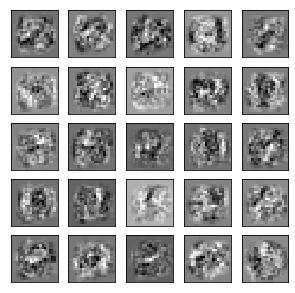

In [46]:
plot_hidden_layer(final_theta)
plt.show()